# Chapter 4

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
import numpy as np

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [3]:
import thinkstats2
import thinkplot

## Examples

One more time, I'll load the data from the NSFG.

In [4]:
import first

live, firsts, others = first.MakeFrames()

And compute the distribution of birth weight for first babies and others.

In [5]:
first_wgt = firsts.totalwgt_lb
first_wgt_dropna = first_wgt.dropna()
print('Firsts', len(first_wgt), len(first_wgt_dropna))
 
other_wgt = others.totalwgt_lb
other_wgt_dropna = other_wgt.dropna()
print('Others', len(other_wgt), len(other_wgt_dropna))

first_pmf = thinkstats2.Pmf(first_wgt_dropna, label='first')
other_pmf = thinkstats2.Pmf(other_wgt_dropna, label='other')

Firsts 4413 4363
Others 4735 4675


We can plot the PMFs on the same scale, but it is hard to see if there is a difference.

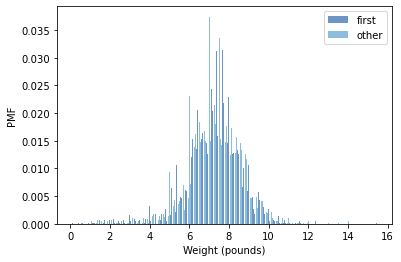

In [6]:
width = 0.4 / 16

# plot PMFs of birth weights for first babies and others
thinkplot.PrePlot(2)
thinkplot.Hist(first_pmf, align='right', width=width)
thinkplot.Hist(other_pmf, align='left', width=width)
thinkplot.Config(xlabel='Weight (pounds)', ylabel='PMF')

`PercentileRank` computes the fraction of `scores` less than or equal to `your_score`.

In [7]:
def PercentileRank(scores, your_score):
    count = 0
    for score in scores:
        if score <= your_score:
            count += 1

    percentile_rank = 100.0 * count / len(scores)
    return percentile_rank

If this is the list of scores.

In [8]:
t = [55, 66, 77, 88, 99]

If you got the 88, your percentile rank is 80.

In [9]:
PercentileRank(t, 88)

80.0

`Percentile` takes a percentile rank and computes the corresponding percentile. 

In [10]:
def Percentile(scores, percentile_rank):
    scores.sort()
    for score in scores:
        if PercentileRank(scores, score) >= percentile_rank:
            return score

The median is the 50th percentile, which is 77.

In [11]:
Percentile(t, 50)

77

Here's a more efficient way to compute percentiles.

In [12]:
def Percentile2(scores, percentile_rank):
    scores.sort()
    index = percentile_rank * (len(scores)-1) // 100
    return scores[int(index)]

Let's hope we get the same answer.

In [13]:
Percentile2(t, 50)

77

The Cumulative Distribution Function (CDF) is almost the same as `PercentileRank`.  The only difference is that the result is 0-1 instead of 0-100.

In [14]:
def EvalCdf(sample, x):
    count = 0.0
    for value in sample:
        if value <= x:
            count += 1

    prob = count / len(sample)
    return prob

In this list

In [15]:
t = [1, 2, 2, 3, 5]

We can evaluate the CDF for various values:

In [16]:
EvalCdf(t, 0), EvalCdf(t, 1), EvalCdf(t, 2), EvalCdf(t, 3), EvalCdf(t, 4), EvalCdf(t, 5)

(0.0, 0.2, 0.6, 0.8, 0.8, 1.0)

Here's an example using real data, the distribution of pregnancy length for live births.

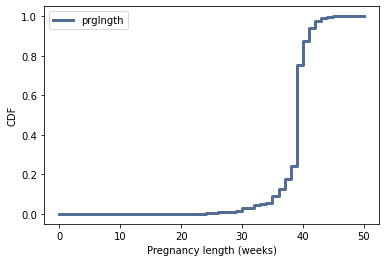

In [17]:
cdf = thinkstats2.Cdf(live.prglngth, label='prglngth')
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Pregnancy length (weeks)', ylabel='CDF', loc='upper left')

`Cdf` provides `Prob`, which evaluates the CDF; that is, it computes the fraction of values less than or equal to the given value.  For example, 94% of pregnancy lengths are less than or equal to 41.

In [18]:
cdf.Prob(41)

0.9406427634455619

`Value` evaluates the inverse CDF; given a fraction, it computes the corresponding value.  For example, the median is the value that corresponds to 0.5.

In [19]:
cdf.Value(0.5)

39

In general, CDFs are a good way to visualize distributions.  They are not as noisy as PMFs, and if you plot several CDFs on the same axes, any differences between them are apparent.

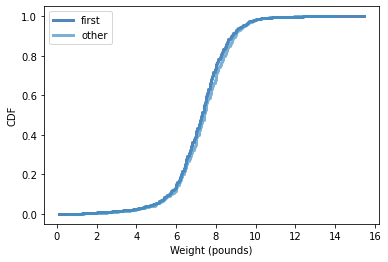

In [20]:
first_cdf = thinkstats2.Cdf(firsts.totalwgt_lb, label='first')
other_cdf = thinkstats2.Cdf(others.totalwgt_lb, label='other')

thinkplot.PrePlot(2)
thinkplot.Cdfs([first_cdf, other_cdf])
thinkplot.Config(xlabel='Weight (pounds)', ylabel='CDF')

In this example, we can see that first babies are slightly, but consistently, lighter than others.

We can use the CDF of birth weight to compute percentile-based statistics.

In [21]:
weights = live.totalwgt_lb
live_cdf = thinkstats2.Cdf(weights, label='live')

Again, the median is the 50th percentile.

In [22]:
median = live_cdf.Percentile(50)
median

7.375

The interquartile range is the interval from the 25th to 75th percentile.

In [23]:
iqr = (live_cdf.Percentile(25), live_cdf.Percentile(75))
iqr

(6.5, 8.125)

We can use the CDF to look up the percentile rank of a particular value.  For example, my second daughter was 10.2 pounds at birth, which is near the 99th percentile.

In [24]:
live_cdf.PercentileRank(10.2)

98.82717415357381

If we draw a random sample from the observed weights and map each weigh to its percentile rank.

In [25]:
sample = np.random.choice(weights, 100, replace=True)
ranks = [live_cdf.PercentileRank(x) for x in sample]

The resulting list of ranks should be approximately uniform from 0-1.

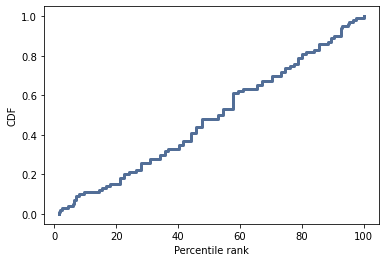

In [26]:
rank_cdf = thinkstats2.Cdf(ranks)
thinkplot.Cdf(rank_cdf)
thinkplot.Config(xlabel='Percentile rank', ylabel='CDF')

That observation is the basis of `Cdf.Sample`, which generates a random sample from a Cdf.  Here's an example.

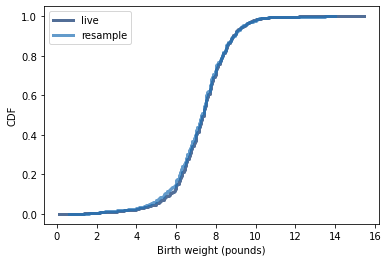

In [27]:
resample = live_cdf.Sample(1000)
thinkplot.Cdf(live_cdf)
thinkplot.Cdf(thinkstats2.Cdf(resample, label='resample'))
thinkplot.Config(xlabel='Birth weight (pounds)', ylabel='CDF')

This confirms that the random sample has the same distribution as the original data.

## Exercises

**Exercise:** How much did you weigh at birth? If you don’t know, call your mother or someone else who knows. Using the NSFG data (all live births), compute the distribution of birth weights and use it to find your percentile rank. If you were a first baby, find your percentile rank in the distribution for first babies. Otherwise use the distribution for others. If you are in the 90th percentile or higher, call your mother back and apologize.

**Exercise:** The numbers generated by `numpy.random.random` are supposed to be uniform between 0 and 1; that is, every value in the range should have the same probability.

Generate 1000 numbers from `numpy.random.random` and plot their PMF.  What goes wrong?

Now plot the CDF. Is the distribution uniform?